In [173]:
import matplotlib.pyplot as plt
import pybedtools as pbt
import glob
from tqdm import tqdm
import numpy as np
from IPython.display import clear_output
import seaborn.apionly as sns
from scipy.stats import mannwhitneyu, poisson
import json
from ipyparallel import Client
import os

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.7)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

### First we need to create arrays consisting of expectation scores around center of each TRF2 peak

#### Creating a general resource. Merging 1MB regions of expectation scores into chromosomal arrays

In [ ]:
def save_scores(chrom, chrom_info, strand):
    scores_dir = './data/quad_graph_single_base_scores/%s/%s/*_exp_score.npy' % (
            chrom, strand)
    chrom_score = np.zeros(chrom_info[chrom])
    for fn in tqdm(glob.glob(scores_dir), desc="%s %s" % (chrom, strand)):
            exp = np.load(fn)
            if exp.shape[0] > 1:
                e_indices = np.array(exp[:, 0], dtype=int)
                e_scores = np.array(exp[:, 1], dtype=float)
                chrom_score[e_indices] += e_scores
    np.save('./data/QG_expectation_scores/%s_%s' % (chrom, strand), chrom_score)
    return True

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

for chrom in chroms:
    save_scores(chrom, chrom_info, 'positive')
    save_scores(chrom, chrom_info, 'negative')

#### Creating peak arrays and their shuffle controls

In [ ]:
def chrom_to_peaks(chrom):
    
    def bed_to_chrom_wise_interval(bed):
        chrom_wise_peaks = {x: [] for x in chroms}
        for i in bed:
            chrom_wise_peaks[i.chrom].append((i.start, i.end))
        return chrom_wise_peaks
    
    pos = numpy.load("%s/%s_positive.npy" % (exp_dir, chrom))
    neg = numpy.load("%s/%s_negative.npy" % (exp_dir, chrom))
    exp_scores = pos + neg

    interval_exp = []
    chrom_wise_peaks = bed_to_chrom_wise_interval(pybedtools.BedTool(bed_file))
    for i in chrom_wise_peaks[chrom]:
        peak_mid = i[0] + (i[1] - i[0])
        interval_exp.append(exp_scores[peak_mid - offset : peak_mid + offset])
    
    shuffle_exp = []
    for i in range(100):
        chrom_wise_peaks = bed_to_chrom_wise_interval(
            pybedtools.BedTool(bed_file).shuffle(chrom=True, g=chrom_info_file))
        temp = []
        for i in chrom_wise_peaks[chrom]:
            peak_mid = i[0] + (i[1] - i[0])
            temp.append(exp_scores[peak_mid - offset : peak_mid + offset])
        shuffle_exp.append(temp)
    return interval_exp, shuffle_exp

with DVIEW.sync_imports():
    import numpy
    import pybedtools

_ = DVIEW.push(dict(
        bed_file=os.path.abspath('./data/TRF2/IDR_peaks.bed'),
        offset=1000,
        exp_dir=os.path.abspath('./data/QG_expectation_scores/'),
        chroms=['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY'],
        chrom_info_file='/home/parashar/scratch/hg19_resource/hg19.genome'
))

peaks_array = []
shuffle_array = [[] for x in range(100)]
for i in DVIEW.map_async(chrom_to_peaks,
                         ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']):
    peaks_array.extend(i[0])
    for j in range(100):
        shuffle_array[j].extend(i[1][j])
np.save('./data/TRF2/idr_peaks_scores', np.array(peaks_array))
np.save('./data/TRF2/idr_shuffle_peaks_scores', np.array(shuffle_array))

### Now lets investigate whether Expectation scores in the TRF2 peak region is actually higher than expectation

In [3]:
peaks_array = np.load('./data/TRF2/idr_peaks_scores.npy')
shuffle_array = []
for i in tqdm(np.load('./data/TRF2/idr_shuffle_peaks_scores.npy')):
    try:
        shuffle_array.append(np.array([list(j) for j in i], dtype=float))
    except:
        pass

100%|██████████| 100/100 [00:50<00:00,  2.01it/s]


In [4]:
a = peaks_array.max(axis=1)
b = np.array([x.max(axis=1) for x in shuffle_array])
print (a.mean(), b.mean())
mannwhitneyu(a, b.mean(axis=0))

0.260258262016 0.1790729718


MannwhitneyuResult(statistic=603919.0, pvalue=4.1405904556861226e-22)

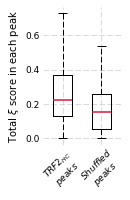

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3))

boxprops = dict(linestyle='-', linewidth=1, color='k')
whiskerprops = dict(linestyle='--', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1.5, color='crimson')

ax.boxplot([a, b[0]], sym='', widths=[0.5, 0.5],
           boxprops=boxprops, 
           medianprops=medianprops, whiskerprops=whiskerprops)
ax.set_ylabel(r'Total $\xi$ score in each peak', fontsize=10)
ax.set_xticklabels([r'$TRF2_{HC}$'+'\n'+'$peaks$', r'$Shuffled$'+'\n'+'$peaks$'],
                   rotation=45, fontsize=10)
clean_axis(ax)

plt.tight_layout()
plt.show()

In [6]:
sorted_peaks_array = peaks_array[peaks_array.sum(axis=1).argsort()[::-1]]
sorted_shuffle_array = [i[i.sum(axis=1).argsort()[::-1]] for i in shuffle_array]

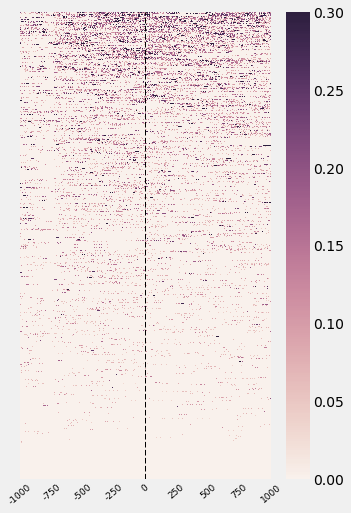

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))

ax = sns.heatmap(sorted_peaks_array, vmax=0.3, 
          xticklabels=[], yticklabels=[], ax=ax)

ax.set_xticks([x+1000 for x in [-1000, -750, -500, -250, 0, 250, 500, 750, 1000]])
ax.set_xticklabels([-1000, -750, -500, -250, 0, 250, 500, 750, 1000], fontsize=9, rotation=40)
ax.set_yticks([])
ax.axvline(1000, ls='--', color='k', lw=1)
plt.show()

### Now we are going to look at motif based approaches and how they overlap the TRF2 binding sites

In [128]:
def make_chrom_wise_bed(bed):
    chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
    chrom_wise = {x:[] for x in chroms}
    for i in bed:
        chrom_wise[i.chrom].append(str(i).rstrip('\n'))
    for chrom in chroms:
         chrom_wise[chrom] = pbt.BedTool('\n'.join(chrom_wise[chrom]), from_string=True)
    return chrom_wise

chrom_wise_peaks = make_chrom_wise_bed(pbt.BedTool('./data/TRF2/IDR_peaks.bed'))
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
shuffled_chrom_wise_peaks = [
    make_chrom_wise_bed(pbt.BedTool('./data/TRF2/IDR_peaks.bed').shuffle(
        chrom=True, g='/home/parashar/scratch/hg19_resource/hg19.genome')) for x in range(100)
]

In [27]:
def calc_overlap(chrom, i):
    return shuffled_chrom_wise_peaks[i][chrom].intersect(g4_bed, u=True).count()
    
with DVIEW.sync_imports():
    import pybedtools

_ = DVIEW.push(dict(
    shuffled_chrom_wise_peaks=shuffled_chrom_wise_peaks,
))
pbt.cleanup()

overlap = {}
shuffle_overlap = {}
for loop in [1,3,5,7,10,15]:
    for bulge in [0, 3]:
        overlap['%d_%d' % (loop, bulge)] = []
        shuffle_overlap['%d_%d' % (loop, bulge)] = []
        for chrom in chroms:
            print (loop, bulge, chrom)
            g4_bed_file = '/home/parashar/scratch/quadruplexes/hg19/g3_%d_%d_%s_nov.bed' % (
                    loop, bulge, chrom)
            g4_bed = pbt.BedTool(g4_bed_file)
            overlap['%d_%d' % (loop, bulge)].append(
                chrom_wise_peaks[chrom].intersect(g4_bed, u=True).count()
            )
            _ = DVIEW.push(dict(
                g4_bed=g4_bed
            ))
            temp = DVIEW.map_sync(calc_overlap, [chrom for x in range(100)], range(100))
            shuffle_overlap['%d_%d' % (loop, bulge)].append(temp)
            clear_output()

with open('./data/TRF2/motif_overlap.json', 'w') as OUT:
    json.dump(overlap, OUT, indent=2)
with open('./data/TRF2/shuffle_motif_overlap.json', 'w') as OUT:
    json.dump(shuffle_overlap, OUT, indent=2)

In [28]:
overlap =  json.load(open('./data/TRF2/motif_overlap.json'))
shuffle_overlap = json.load(open('./data/TRF2/shuffle_motif_overlap.json'))

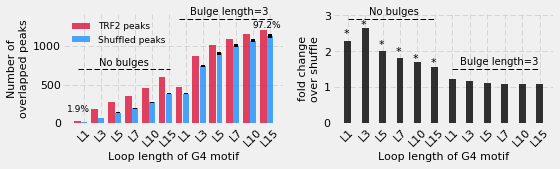

In [193]:
plt.style.use('fivethirtyeight')
def clean_axis(ax, hidegrids=False):
    ax.xaxis.set_tick_params(labelsize=11)
    ax.yaxis.set_tick_params(labelsize=11)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    if hidegrids is True:
        ax.grid(lw=0)
    else:
        ax.grid(which='major', linestyle='--', alpha=0.7)
    return True

fig, axis = plt.subplots(1, 2, figsize=(8, 2.5))

ax = axis[0]

ind1  = [0.5+x for x in range(len(overlap))]
vals1 = [sum(overlap['%d_0' % x]) for x in [1,3,5,7,10,15]] + \
        [sum(overlap['%d_3' % x]) for x in [1,3,5,7,10,15]]
ax.bar(ind1, vals1, width=0.4, label='TRF2 peaks', color='crimson', alpha=0.8)
ind2  = [0.9+x for x in range(len(overlap))]
vals2 = [np.array(shuffle_overlap['%d_0' % x]).mean(axis=1).sum() for x in [1,3,5,7,10,15]] + \
        [np.array(shuffle_overlap['%d_3' % x]).mean(axis=1).sum() for x in [1,3,5,7,10,15]]
yerr = [np.array(shuffle_overlap['%d_0' % x]).mean(axis=1).std() for x in [1,3,5,7,10,15]] + \
       [np.array(shuffle_overlap['%d_3' % x]).mean(axis=1).std() for x in [1,3,5,7,10,15]]
ax.bar(ind2, vals2, width=0.35, yerr=yerr, label='Shuffled peaks', color='dodgerblue', alpha=0.8)

ax.plot([0.5, 6], [700, 700], lw=1, color='k', ls='--')
ax.plot([6.5, 12], [1350, 1350], lw=1, color='k', ls='--')
ax.text(0.16, 0.52, 'No bulges', transform=ax.transAxes, fontsize=10)
ax.text(0.575, 0.99, 'Bulge length=3', transform=ax.transAxes, fontsize=10)

tot_peaks = sum([x.count() for x in chrom_wise_peaks.values()])
fp = (vals1[0]/tot_peaks)*100
lp = (vals1[-1]/tot_peaks)*100
ax.text(0.01, 0.1, "%.1f%%" % fp, transform=ax.transAxes, fontsize=9)
ax.text(0.86, 0.87, "%.1f%%" % lp, transform=ax.transAxes, fontsize=9)

ax.set_xticks(ind2)
ax.set_xticklabels(['L%d' % x for x in [1,3,5,7,10,15]] +
                   ['L%d' % x for x in [1,3,5,7,10,15]], rotation=45)
ax.set_xlabel('Loop length of G4 motif', fontsize=11)
ax.set_ylabel('Number of\noverlapped peaks', fontsize=11)
ax.legend(frameon=False, fontsize=9)
clean_axis(ax)


#---------------------------------------------------------------------------------------------
ax = axis[1]

shuf_vals = [np.array(shuffle_overlap['%d_0' % x]).sum(axis=0) for x in [1,3,5,7,10,15]] + \
            [np.array(shuffle_overlap['%d_3' % x]).sum(axis=0) for x in [1,3,5,7,10,15]]
pvals = [poisson.pmf(i, mu=j.mean())*tot_peaks for i,j in zip(vals1, shuf_vals)]

vals = np.array(vals1) / np.array(vals2)
ax.bar(ind1, vals, width=0.4, label='TRF2 peaks', color='k', alpha=0.8)
ax.plot([0.5,5.5], [2.9, 2.9], lw=1, color='k', ls='--')
ax.plot([6.5,11.5], [1.5, 1.5], lw=1, color='k', ls='--')
ax.text(0.16, 0.99, 'No bulges', transform=ax.transAxes, fontsize=10)
ax.text(0.575, 0.53, 'Bulge length=3', transform=ax.transAxes, fontsize=10)
ax.set_xticks(ind1)
ax.set_xticklabels(['L%d' % x for x in [1,3,5,7,10,15]] +
                   ['L%d' % x for x in [1,3,5,7,10,15]], rotation=45)
ax.set_xlabel('Loop length of G4 motif', fontsize=11)
ax.set_ylabel('Fold change\nover shuffle', fontsize=11)
for x,y in zip(range(6), [2.4, 2.65, 2.1, 1.9, 1.7, 1.6]):
    ax.text(ind1[x]-0.25, y, '*', fontsize=11)
clean_axis(ax)

plt.tight_layout()
plt.show()

In [194]:
pvals

[0.17834604786767594,
 4.1046105980750708e-26,
 5.6847394213504276e-23,
 6.1615200227555592e-22,
 3.0371559805667941e-22,
 1.5997131354579705e-21,
 0.0019676477401053853,
 0.0013255688978465814,
 0.059770259156931474,
 0.23067765667753204,
 0.4019219931821098,
 0.64662644301160932]